In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from mpl_toolkits.mplot3d import Axes3D

os.chdir("C:/Users/SAI VAMSHI/Desktop/Datacamp/Unsupervised_Learning")

In [2]:
wheats = pd.read_csv("wheat_seeds_uci.csv")
wheats.head()

,area,perimeter,compact,ker_len,ker_wid,asymmetry_coef,ker_groove_len,label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


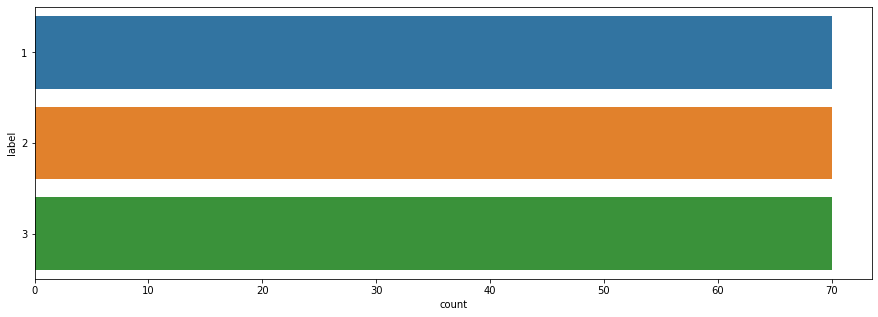

In [3]:
#Data Visualization - Label - countplot
fig,ax =  plt.subplots(figsize = (15 , 5))
sns.countplot(y = 'label' , data = wheats)
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


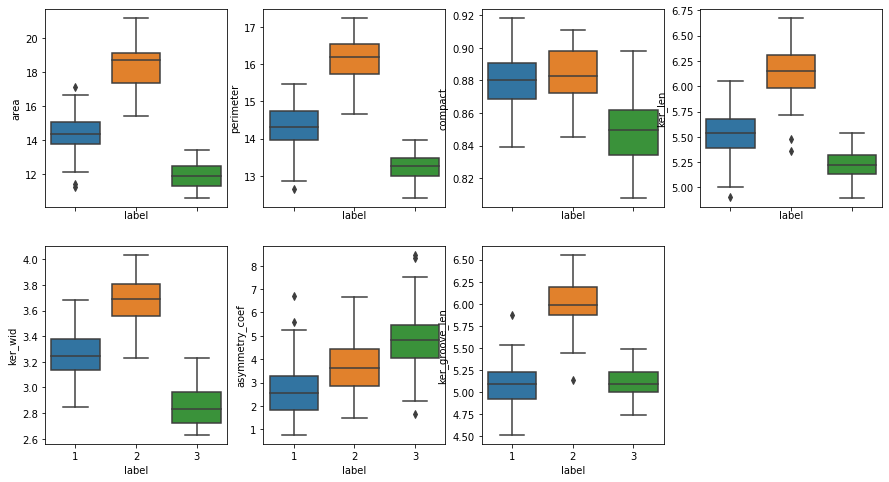

In [4]:
#Data Visualozation - Label vs other continuous variables - box plot
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize=(15,8),sharex=True)
for axi,col_name in zip(axs.flat,list(wheats.columns)):
    sns.boxplot(x="label",y=col_name,data=wheats,ax=axi)
fig.delaxes(ax = axs[1,3])
fig.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


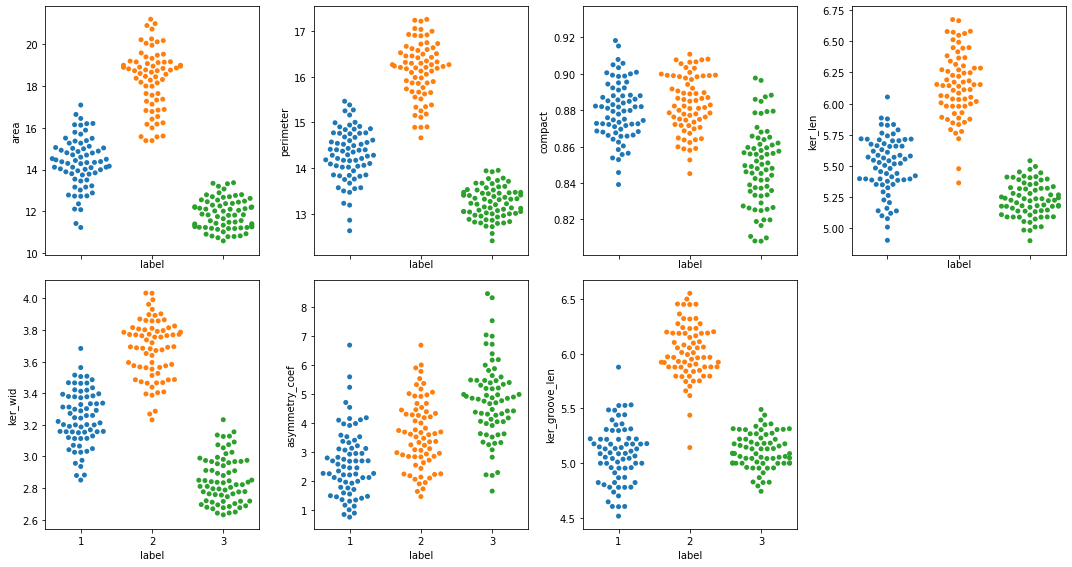

In [5]:
#Data Visualozation - Label vs other continuous variables - swarmplot
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize=(15,8),sharex=True)
for axi,col_name in zip(axs.flat,list(wheats.columns)):
    sns.swarmplot(x="label",y=col_name,data=wheats,ax=axi)
fig.delaxes(ax = axs[1,3])
fig.tight_layout()
fig.show()

From the above graphs we can see that there is a good segregation between variables. But many variables have a similar distribution in terms of labels. We can use PCA to reduce some dimensions

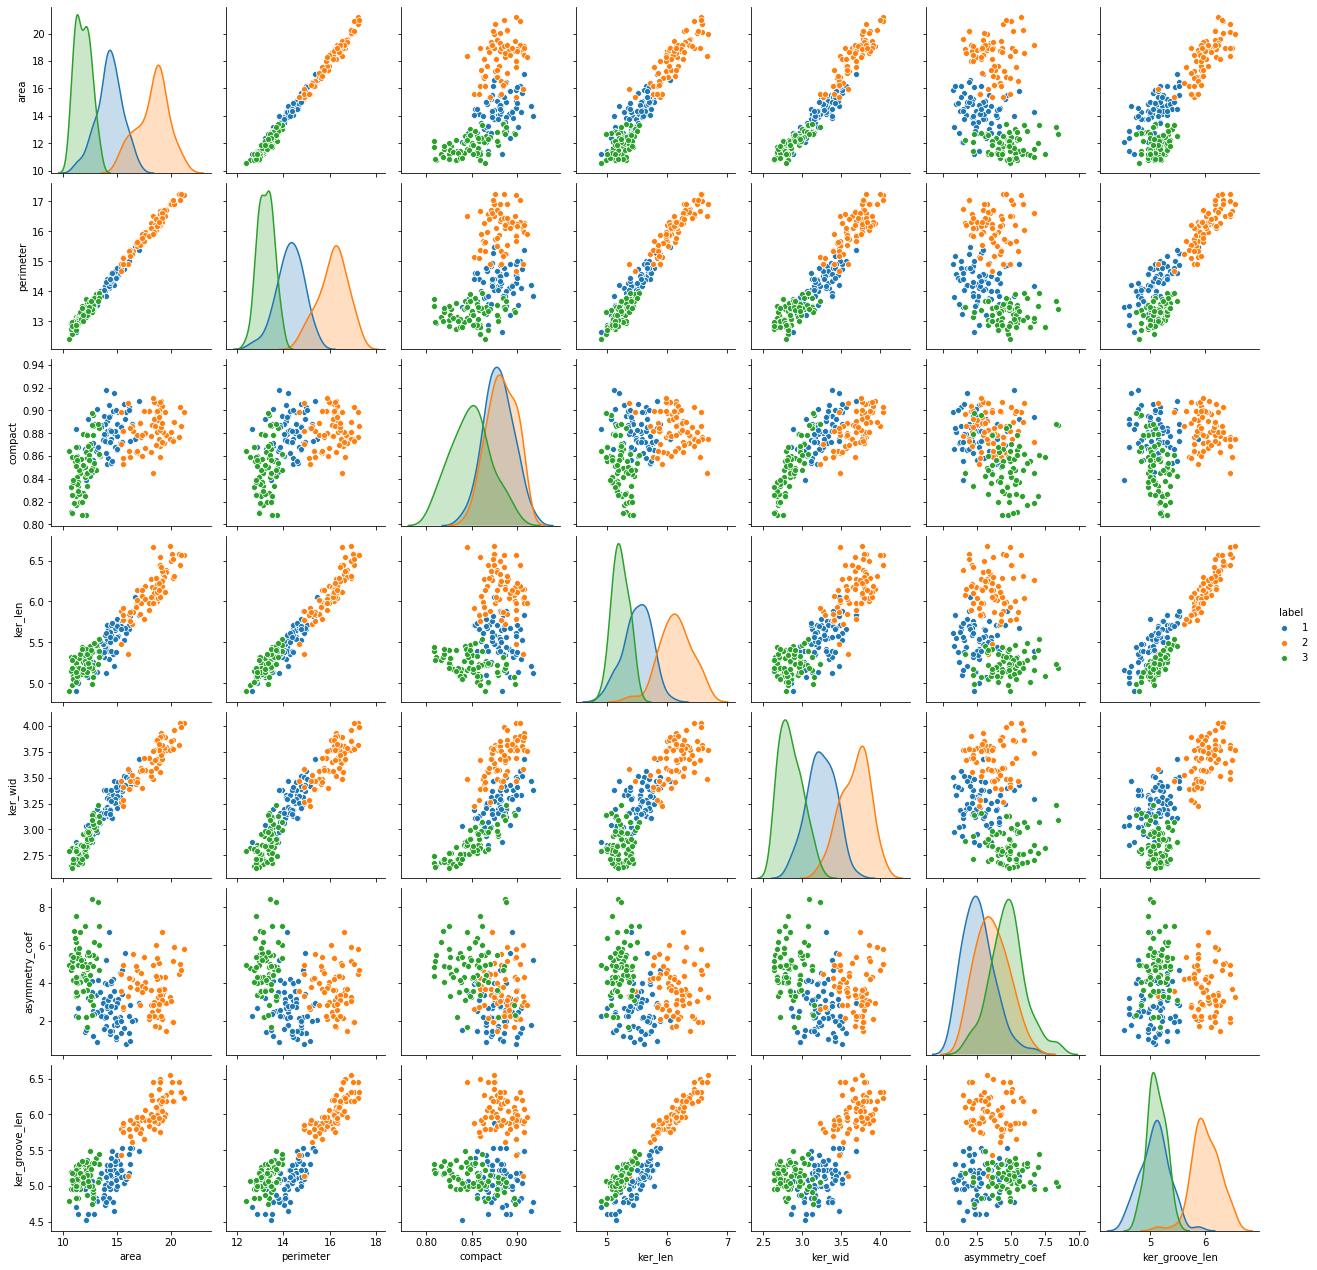

In [6]:
#Data Visualization - Continuous Variables - pairplot
sns.pairplot(data=wheats,hue="label")

We can confirm from the above graph that Area, Perimeter, Kernel Length, Kernel Width and Kernel groove length are similar

Let's check using a correlation heat map

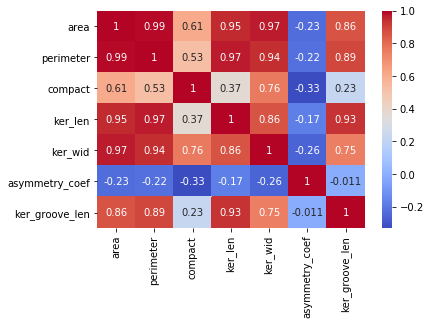

In [7]:
#Data Visualization - Continuous Variables - heatmap (Area, Compactness, Assymetry Coefficient)
sns.heatmap(wheats[list(wheats.columns[:-1])].corr(),annot=True,cmap="coolwarm")
plt.show()

From the above heatmap, we can tell that only assymetry coefficient is different from other variables.

# K-Means Clustering

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


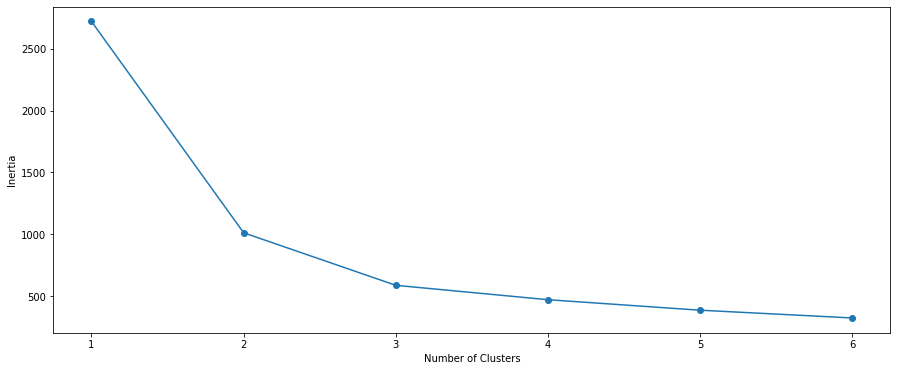

In [8]:
#Checking whether 3 clusters is optimal or not
inertia = []
for c in range(1,7):
    model = KMeans(n_clusters=c)
    model.fit(wheats[list(wheats.columns[:-1])])
    inertia.append(model.inertia_)
fig, ax = plt.subplots(figsize = (15 ,6))
ax.plot(np.arange(1 , 7) , inertia , marker="o")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
fig.show()

3 is the optimal number of clusters. After 3, the reduction in inertia is insignificant

In [9]:
#Validating the clusters
model = KMeans(n_clusters = 3)
model.fit(wheats[list(wheats.columns[:-1])])
label_pred = model.predict(wheats[list(wheats.columns[:-1])])
wheat_preds = pd.DataFrame({"label_act":list(wheats["label"]),"label_kmeans":list(label_pred)})
pd.crosstab(wheat_preds.label_act,wheat_preds.label_kmeans)

label_kmeans,0,1,2
label_act,,,
1,60,1,9
2,10,60,0
3,2,0,68


We are able to segregate 188 out of 210 correctly. To improve this we can standardize data so that mean is 0 and variance is 1

In [10]:
#k-Means Clustering - Standardisation
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3)
pipeline = make_pipeline(scaler,kmeans)
pipeline.fit(wheats[list(wheats.columns[:-1])])
labels_pred_std = pipeline.predict(wheats[list(wheats.columns[:-1])])
wheat_preds["labels_kmeans_std"] = labels_pred_std
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_kmeans_std)

labels_kmeans_std,0,1,2
label_act,,,
1,2,62,6
2,65,5,0
3,0,4,66


After standardisation, 193 samples are grouped correctly compared to 188 without standardisation

# Hierarchical Clustering - Agglomerative

In [11]:
samples = np.array(wheats[list(wheats.columns[:-1])])
samples.shape

(210, 7)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


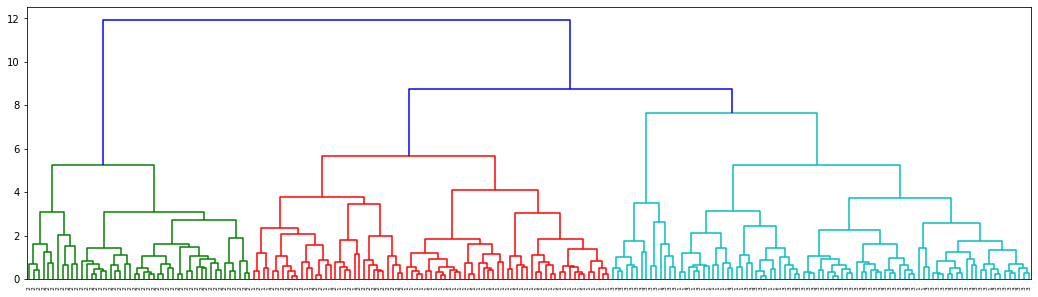

In [12]:
#Agglomerative Clustering - Fathest point distance - Dendrogram
fig, ax = plt.subplots(figsize=(18,5))
mergings = linkage(samples,method="complete")
dendrogram(mergings,
           labels=list(wheats["label"]),
           leaf_rotation=90,
           leaf_font_size=6,
)
fig.show()

In [13]:
#Agglomerative Clustering - Farthest point distance - Clustering
agg_clus = AgglomerativeClustering(n_clusters = 3,linkage="complete")
wheat_preds["labels_agg"] = agg_clus.fit_predict(wheats[list(wheats.columns[:-1])])
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_agg)

labels_agg,0,1,2
label_act,,,
1,18,0,52
2,0,47,23
3,70,0,0


Only 169 are correctly segregated (0 in labels_agg is 3,1 is 2 and 2 is 1). Let's try with standardization

In [14]:
#Agglomerative Clustering - Fathest point distance - Clustering - Standardisation
std = StandardScaler()
agg_clus = AgglomerativeClustering(n_clusters = 3,linkage="complete")
pipeline = make_pipeline(std,agg_clus)
pipeline.fit(wheats[list(wheats.columns[:-1])])
wheat_preds["labels_agg_std"] = pipeline.fit_predict(wheats[list(wheats.columns[:-1])])
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_agg_std)

labels_agg_std,0,1,2
label_act,,,
1,20,2,48
2,0,66,4
3,70,0,0


184 obs are correctly clustered -  Improvement from 169 without standardisation.

Now, let's try different distance calculation method

In [15]:
#Agglomerative Clustering - Fathest point distance - Clustering - Standardisation
std = StandardScaler()
agg_clus = AgglomerativeClustering(n_clusters = 3,linkage="ward",affinity="euclidean")
pipeline = make_pipeline(std,agg_clus)
pipeline.fit(wheats[list(wheats.columns[:-1])])
wheat_preds["labels_agg_std_ward"] = pipeline.fit_predict(wheats[list(wheats.columns[:-1])])
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_agg_std_ward)

labels_agg_std_ward,0,1,2
label_act,,,
1,64,4,2
2,4,66,0
3,5,0,65


Huge improvement over previous iterations. 195 are correctly grouped

We were not able to visualize K-Means or Agglomerative clustering properly because of >3 dimensions. So let's o t-SNE visualization

# t-SNE Visualization

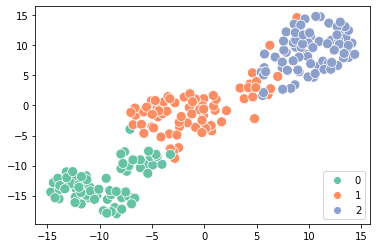

In [16]:
#t-SNE visualization - KMeans post standardisation
model = TSNE(learning_rate = 200)
tsne_features = model.fit_transform(samples)
sns.scatterplot(tsne_features[:,0],tsne_features[:,1],hue=list(wheat_preds.labels_kmeans_std),palette="Set2",s=100)
plt.legend(loc="lower right")
plt.show()

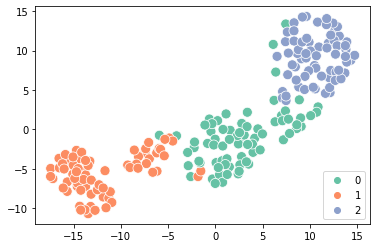

In [17]:
#t-SNE visualization - Agglomerative Clustering post standardisation
model = TSNE(learning_rate = 200)
tsne_features = model.fit_transform(samples)
sns.scatterplot(tsne_features[:,0],tsne_features[:,1],hue=list(wheat_preds.labels_agg_std_ward),palette="Set2",s=100)
plt.legend(loc="lower right")
plt.show()

We can also reduce the number of features using PCA and then visualize

# Principal Component Analysis

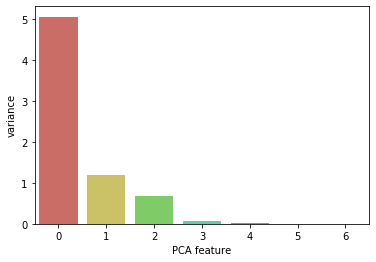

In [18]:
#PCA - Explained Variance
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler,pca)
pipeline.fit(wheats[list(wheats.columns[:-1])])
features = range(pca.n_components_)
sns.barplot(x=np.arange(0,7), y=pca.explained_variance_,palette="hls")
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

We can see that one feature explains most of the variance and first three features explains almost 99% of the variance in the data

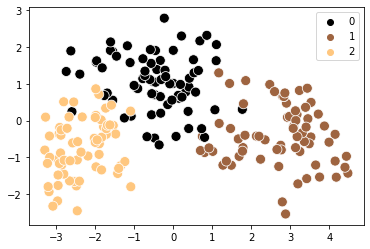

In [19]:
#PCA - Two components - Agglomerative Clustering post standardisation
pca_features = pipeline.transform(wheats[list(wheats.columns[:-1])])
sns.scatterplot(pca_features[:,0],pca_features[:,1],hue=list(wheat_preds.labels_agg_std_ward),palette="copper",s=100)
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


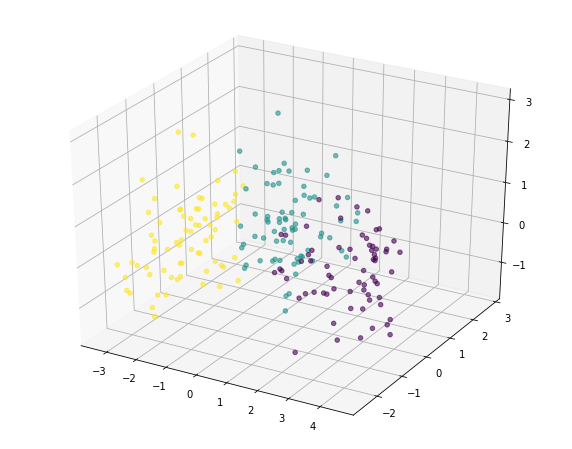

In [20]:
#PCA - Three components - K Means Clustering post standardisation
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_features[:,0],pca_features[:,1],pca_features[:,2],c=list(wheat_preds.labels_kmeans_std),alpha=0.6)
fig.show()

We can also use NMF to reduce the dimensions. The components in NMF are interpretable unlike in PCA

# Non-negative Matrix Factorization (NMF)

In [21]:
#NMF - Interpretability
model = NMF(n_components = 2)
nmf_features = model.fit_transform(wheats[list(wheats.columns[:-1])])
components_df = pd.DataFrame(model.components_,columns=list(wheats.columns[:-1]))
components_df

,area,perimeter,compact,ker_len,ker_wid,asymmetry_coef,ker_groove_len
0,12.576056,10.875632,0.597138,4.114347,2.521553,0.969851,3.909609
1,0.000000,4.408396,0.422671,1.984195,0.713514,7.044990,2.066149


First component is related to area, perimeter. Second component is related to assymetry coefficent. We can also confirm this from the pairplots we observed in the beginning.

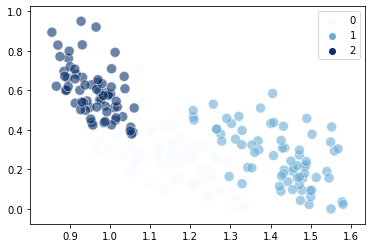

In [22]:
#NMF - Visualization
nmf = NMF(n_components = 2)
norm_features = nmf.fit_transform(wheats[list(wheats.columns[:-1])])
sns.scatterplot(norm_features[:,0],norm_features[:,1],hue=list(wheat_preds.labels_agg_std_ward),palette="Blues",alpha=0.6,s=100)
plt.show()

In this exercise, K-Means Clustering and Agglomerative Clustering are the clustering techniques used. Also, PCA, t-SNE and NMF are some dimensionality reduction techniques used to visualize the unsupervised learning techniques